# Evaluate Proxima Performance
There are a few things we want to watch to see if Proxima is working as intended:
1. Is the machine learning model getting used more often?
2. Is the machine learning model getting better?

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import json

Configuration

In [2]:
run_dir: str = './runs/si-vacancy-2x2x2-blyp-temp=800.0-method=blyp-d54148b7/'

In [3]:
run_dir = Path(run_dir)
params = json.loads((run_dir / 'params.json').read_text())

## Load in run data
We are going to look at the log file produced by the run script, which is line-delimited JSON records

In [4]:
data = pd.read_json(run_dir / 'proxima-log.json', lines=True)
data.tail()

,step_time,energy,maximum_force,stress,temperature,volume,used_surrogate,proxima_alpha,proxima_threshold,last_uncer,last_error
5,54.647321,-6687.088334,1.130646,"[-0.001391099826609, -0.000513442775499, -0.00...",585.106654,1323.325206,False,17.941083,0.0,0.042230,1.106796
6,54.618786,-6686.876616,1.337029,"[-0.0017635049355050002, -0.000697222438393, -...",558.390523,1323.664675,False,22.168878,0.0,0.044519,1.308866
7,53.818875,-6686.639136,1.536311,"[-0.002175426721098, -0.0009192779159860001, -...",528.533855,1324.018043,False,25.862943,0.0,0.046706,1.504121
8,66.265617,-6686.381634,1.726512,"[-0.0026160756482300003, -0.001170145283157, -...",496.247887,1324.387924,False,25.651226,0.0,0.223154,1.581477
9,57.983395,-6686.110290,1.905514,"[-0.003073981341508, -0.0014396146467390001, -...",462.295150,1324.776244,False,21.336966,0.0,0.243473,1.744348


## Sanity Check: Plot Energy and Volume over Time
The energy and volume should not change suddenly during the run

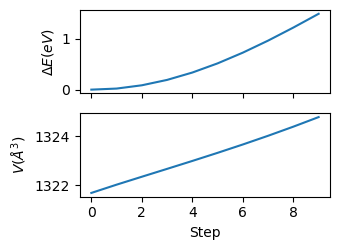

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.6), sharex=True)

ax = axs[0]
ax.plot(data.index, data['energy'] - data['energy'].iloc[0], '-')
ax.set_ylabel('$\\Delta E (eV)$')

ax = axs[1]
ax.plot(data.index, data['volume'], '-')
ax.set_ylabel('$V (\\AA^3)$')

ax.set_xlim(ax.get_xlim())
ax.set_xlabel('Step')

fig.tight_layout()

## Plot the model error
The `last_error` column captures the error of the surrogate model the last time the target function was used. So, it is only meaningful on timesteps where `used_surrogate` is false.

We want to see the steps at which we use the model become less frequent

In [6]:
target_ran = data.query('not used_surrogate')

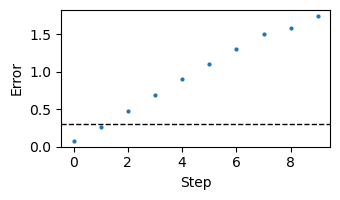

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.scatter(target_ran.index, target_ran['last_error'], s=4)
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [params['target_error']]*2, 'k--', lw=1)

ax.set_xlabel('Step')
ax.set_ylabel('Error')

fig.tight_layout()

## Plot the Controller Performance
The proxima controller updates a threshold ($T$) and a relationship between UQ signal and system error ($\alpha$) each time the target is ran.

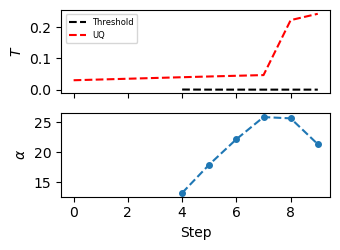

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.6), sharex=True)

ax = axs[0]
ax.plot(target_ran.index, target_ran['proxima_threshold'], 'k--', ms=4, label='Threshold')
ax.plot(target_ran.index, target_ran['last_uncer'], 'r--', ms=4, label='UQ')
ax.set_ylabel('$T$')
ax.legend(fontsize=6)

ax = axs[1]
ax.plot(target_ran.index, target_ran['proxima_alpha'], '--o', ms=4)
ax.set_ylabel('$\\alpha$')

ax.set_xlim(ax.get_xlim())
ax.set_xlabel('Step')

fig.tight_layout()